# Imports

In [7]:
from metrics import amape_score

import logging
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

In [24]:
import importlib
import sin_model
importlib.reload(sin_model)
from sin_model import *

# Multiwave Data Generation

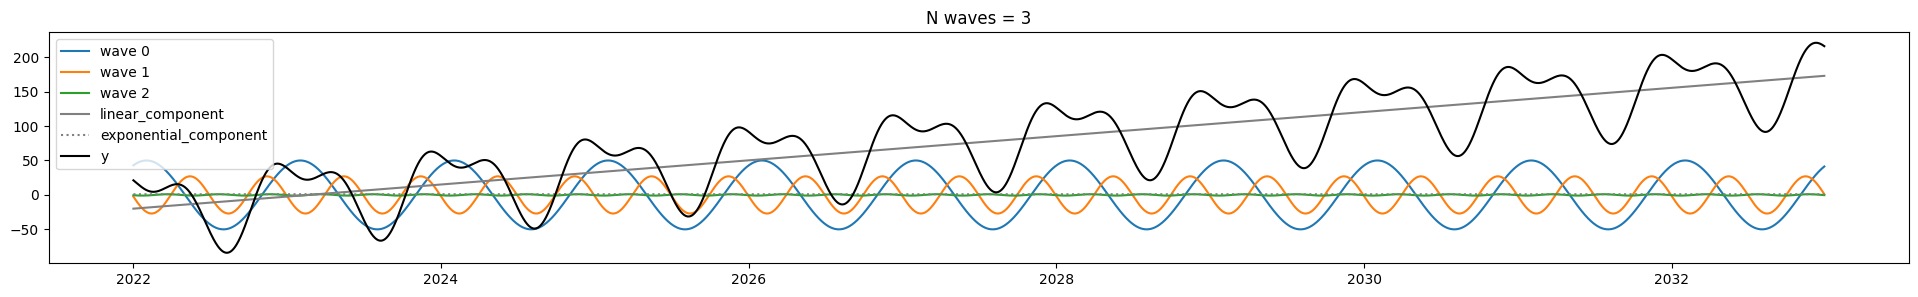

In [9]:
plt.figure(figsize=(24,3))
n_years = np.random.randint(1, 15)
period_starts = pd.Timestamp('2022-01-01')
duration_days = 365 * n_years
period_ends = period_starts + pd.Timedelta(days=duration_days)
x_date = pd.date_range(period_starts, period_ends, freq='D')[:-1]
N = 3
X = np.linspace(1, duration_days, duration_days)
a = np.random.randint(-500, 500) / (n_years * 365.25)

waves = {}
for i in range(N):
    frequency = 2 * np.pi / 365.25 * (i + 1)

    beta = 1
    elevation_power = 0
    amplitude_change_power = 0
    variation = True

    amplitude = np.random.randint(-100, 100)
    phase_shift = np.random.randint(-180, 180)
  
    
    b = np.random.randint(-100, 100)

    if not variation:
        waves[i] = amplitude * np.sin(frequency * X + phase_shift)
    else:
        waves[i] = amplitude * (X**amplitude_change_power) * np.sin(X**beta * frequency + phase_shift)

    plt.plot(x_date, waves[i], label=f'wave {i}')
y = np.sum(list(waves.values()), axis=0)
linear_component = a * X + b
exponential_component = X**elevation_power
y += linear_component
y += exponential_component
plt.plot(x_date, linear_component, color='grey', label='linear_component')
plt.plot(x_date, exponential_component, color='grey', label='exponential_component', linestyle='dotted')
plt.plot(x_date, y, color='black', label='y')
plt.legend()
plt.title(f'N waves = {N}')
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, shuffle=False)

# Test the model

## Manual relative wavelengths

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Wave_1 (Functional)            (None, 1)            9           ['input[0][0]']                  
                                                                                                  
 Wave_0.5 (Functional)          (None, 1)            9           ['input[0][0]']                  
                                                                                                  
 Wave_0.333 (Functional)        (None, 1)            9           ['input[0][0]']                  
                                                                                            

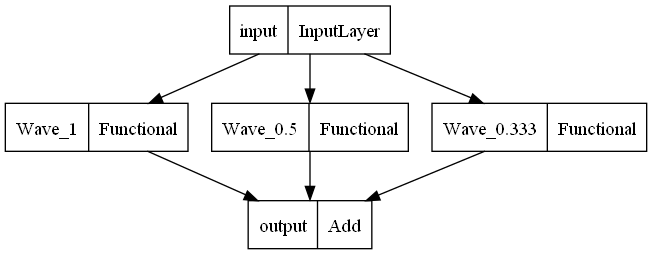

In [25]:
multiwave_model = get_multiwave_model(X_train, y_train, waves=[1, 1/2, 1/3], learning_rate=0.1)
tf.keras.utils.plot_model(multiwave_model)

32/32 [==============================] - 0s 1ms/step


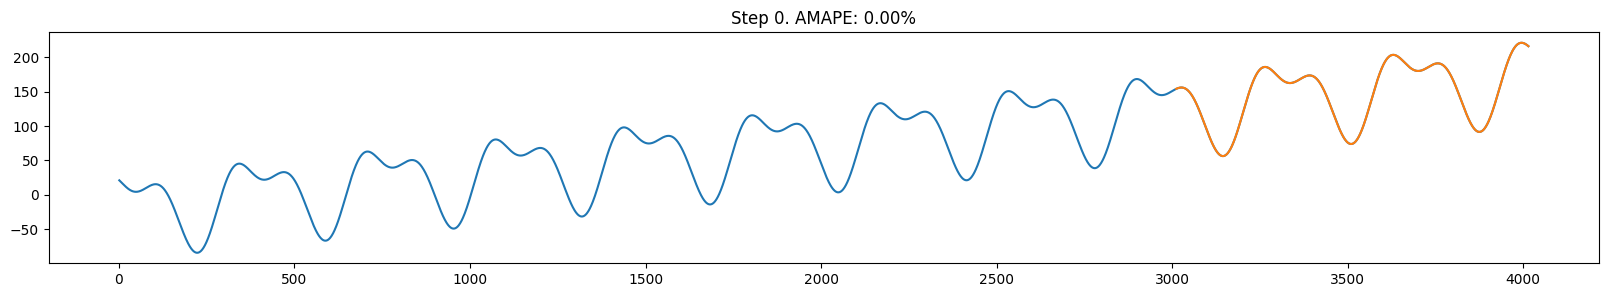

In [26]:
for step in range(1):
  multiwave_model.fit(
      X_train,
      y_train,
      epochs=50,
      verbose=False
      )
  y_pred = multiwave_model.predict(X_test)
  amape =  amape_score(y_test, y_pred, reference=y_train)
  fig = plt.figure(figsize=(20,3))
  plt.plot(X.flatten(), y)
  plt.plot(X_test.flatten(), y_pred)
  plt.title(f'Step {step}. AMAPE: {amape:.2f}%')
  plt.show()

In [17]:
multiwave_model.weights

[<tf.Variable 'phase_shift/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Variable 'frequency/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.01720242]], dtype=float32)>,
 <tf.Variable 'phase_shift_amplifier/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.0173008]], dtype=float32)>,
 <tf.Variable 'linear_rotation/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.1265465]], dtype=float32)>,
 <tf.Variable 'y_shift/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[54.12467]], dtype=float32)>,
 <tf.Variable 'linear_rotation_handler/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.12654652]], dtype=float32)>,
 <tf.Variable 'y_shift_amplifier/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.11692707]], dtype=float32)>,
 <tf.Variable 'sin/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Variable 'amplitude/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[49.998486]], dtype=float32)>,
 <tf.Variabl

## Automatically generated relative wavelengths

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Wave_0.25 (Functional)         (None, 1)            9           ['input[0][0]']                  
                                                                                                  
 Wave_0.333 (Functional)        (None, 1)            9           ['input[0][0]']                  
                                                                                                  
 Wave_0.5 (Functional)          (None, 1)            9           ['input[0][0]']                  
                                                                                            

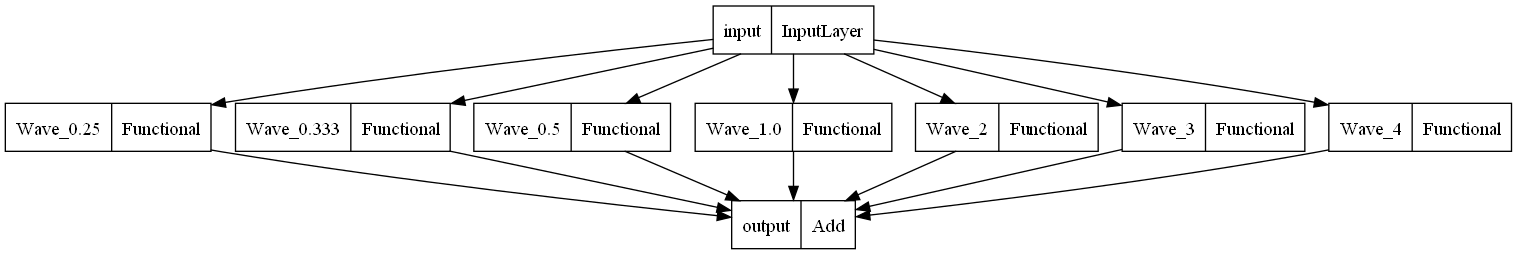

In [27]:
waves = auto_n_relative_wavelengths(7)
multiwave_model = get_multiwave_model(X_train, y_train, waves=waves, learning_rate=0.1)
tf.keras.utils.plot_model(multiwave_model)

32/32 [==============================] - 0s 1ms/step


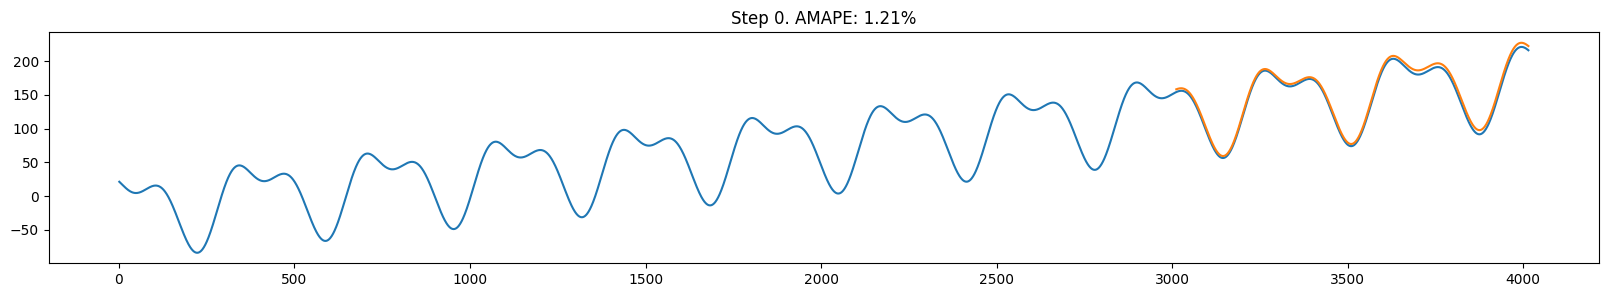

32/32 [==============================] - 0s 1ms/step


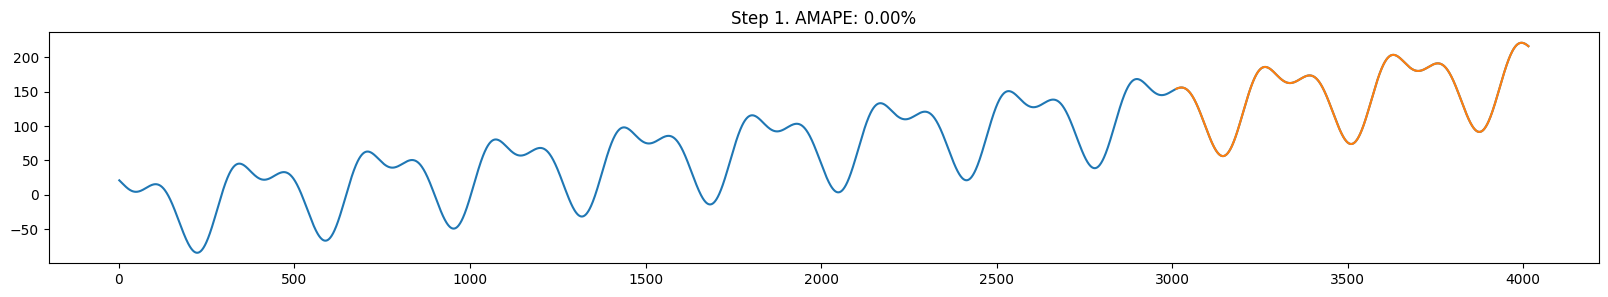

In [28]:
target_amape = 0.1
for step in range(10):
  multiwave_model.fit(
      X_train,
      y_train,
      epochs=50,
      verbose=False
      )
  y_pred = multiwave_model.predict(X_test)
  amape =  amape_score(y_test, y_pred, reference=y_train)
  fig = plt.figure(figsize=(20,3))
  plt.plot(X.flatten(), y)
  plt.plot(X_test.flatten(), y_pred)
  plt.title(f'Step {step}. AMAPE: {amape:.2f}%')
  plt.show()
  if amape <= target_amape:
    break